In [1046]:
#import statements
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import solvers

from sklearn.cross_validation import KFold
import math
import random
from random import shuffle
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [1051]:
'''
Function Desc: Generate linear and non linear datasets from random points.

'''
def generate_Lin_nonlin_Data(n,slider):
    data = []
    np.random.seed(23)
    x1 = (np.random.rand(n) * 2)+slider
    y1 = (np.random.rand(n) * 2)+slider
    x2 = (np.random.rand(n) * 2)-slider
    y2 = (np.random.rand(n) * 2)-slider
    if slider >= 0.8:# adjust the distance between the points for generating data
        plt.title('Linearly separable data')
    else:
        plt.title('Non-linearly separable data')
    #plot the generated data
    plt.scatter(np.array(x1),np.array(y1),c='b')
    plt.scatter(np.array(x2),np.array(y2),c='r')
    plt.show() 
    data.extend([[x1[i], y1[i], 1] for i in xrange(n)])
    data.extend([[x2[i], y2[i], -1] for i in xrange(n)])
    return data

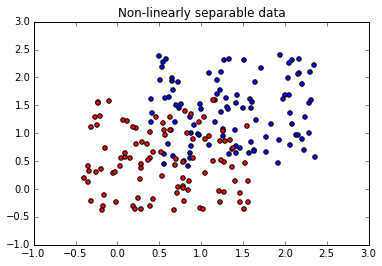

In [1078]:
data = generate_Lin_nonlin_Data(100,0.4)
x=[]
y=[]
for i in data:
    y.append(i[-1])
    x.append(i[0:-1])

In [1079]:
'''
Function desc: load the data 
returns: numpy array containing all features and classes (Iris-versicolor and Iris-virginica)
'''
def load_data():
    iris = datasets.load_iris()
    x = iris['data']
    y = iris['target']
    x,y = x[y != 1], y[y != 1] 
    x=x[:,:2]
    y = y+1
    plt.title("Linearly Separable data - Iris Data set")
    plt.xlabel('sepal_length')
    plt.ylabel("sepal_width")
    plt.scatter(np.array(x[:50,0]),np.array(x[:50,1]),c='b')
    plt.scatter(np.array(x[-50:,0]),np.array(x[-50:,1]),c='r')
    #plt.scatter(np.array(x2),np.array(y2),c='r')
    return x,y

In [1080]:
#x,y=load_data()

In [1081]:
def kernals(x1,x2,kernal_type,deg_gamma):
    if kernal_type == 'polynomial':
        return (np.dot(x1,x2)+1)**deg_gamma
    if kernal_type == 'gaussian':
        t1 = x1-x2
        t2=np.dot(t1,t1.T)*(-1.0/deg_gamma)
        return np.exp(t2)
    
        

In [1082]:
'''
Function desc: Prepare the data to be supplied to the cvxopt solver
'''


def prepare_data(x,y,c,kernel,deg_gamma):
    kern=np.zeros((len(y), len(y)))
    for i in range(np.shape(x)[0]):
        for j in range(np.shape(x)[0]):
            kern[i,j] = kernals(x[i],x[j],kernel,deg_gamma)
    P = cvxopt.matrix(np.outer(y,y) * kern)
    A_temp = np.ones(len(y))*y
    A = cvxopt.matrix(A_temp,(1,len(y)))
    q =  cvxopt.matrix(-1 * np.ones(len(y)))
    b = cvxopt.matrix(0.0)
    g1 = np.diag(np.ones(len(y)) * -1)
    g2 = np.diag(np.ones(len(y)))
    G= cvxopt.matrix(np.vstack((g1,g2)))
    h1 = [0.0 for i in xrange(len(y))]
    h2 = [c for i in xrange(len(y))]
    h_t1 = np.reshape(h1,(len(y),1))
    h_t2=np.reshape(h2,(len(y),1))
    h=cvxopt.matrix(np.vstack((h_t1,h_t2)))
    sol = solvers.qp(P,q,G,h,A,b)
    return sol

In [1083]:
solution = prepare_data(np.array(x),y,0.1,'polynomial',2)
alpha=[]
for i in solution['x']:
    alpha.append(i)

     pcost       dcost       gap    pres   dres
 0: -5.2785e+01 -4.0852e+01  1e+03  2e+01  4e-14
 1: -9.5540e+00 -3.8329e+01  9e+01  1e+00  4e-14
 2: -6.9754e+00 -2.3547e+01  3e+01  3e-01  1e-14
 3: -6.5517e+00 -9.7491e+00  4e+00  3e-02  7e-15
 4: -7.1204e+00 -8.0483e+00  1e+00  7e-03  6e-15
 5: -7.2649e+00 -7.7745e+00  6e-01  3e-03  7e-15
 6: -7.4000e+00 -7.5407e+00  2e-01  7e-04  8e-15
 7: -7.4490e+00 -7.4653e+00  2e-02  6e-05  7e-15
 8: -7.4552e+00 -7.4565e+00  1e-03  4e-06  7e-15
 9: -7.4558e+00 -7.4558e+00  4e-05  9e-08  7e-15
10: -7.4558e+00 -7.4558e+00  1e-06  1e-09  8e-15
Optimal solution found.


In [1084]:
'''
Function desc: Find the support vectors
'''

def find_support_vectors(alfa,x,y):
    sup_vec = []
    sup_vec_x=[]
    sup_vec_y = []
    for i in range(len(alfa)):
        if alfa[i] > 1e-3:
            sup_vec.append(alfa[i])
            sup_vec_x.append(x[i])
            sup_vec_y.append(y[i])
    print "No of. support vectors found",len(sup_vec)
    
    return sup_vec,sup_vec_x,sup_vec_y

In [1085]:
support_vec,support_vec_x,support_vec_y =  find_support_vectors(alpha,x,y)


No of. support vectors found 80


In [1086]:

'''
Function Desc: Calculate the model parameters


'''


def find_w_w0(support_vec,alpha,x,y,support_vec_x,support_vec_y):
    ws=[]
    w0=[]
    w_= np.zeros(np.shape(x)[1])
    for i in range(np.shape(support_vec)[0]):
        w_ += support_vec[i] *support_vec_y[i] * np.array(support_vec_x[i])
    for s in range(np.shape(support_vec_x)[0]):
        w_o = y[s] - np.dot(w_.T,support_vec_x[s])
        w0.append(w_o)
    w_0 = (1./len(support_vec)) * np.sum(w0)
    return (w_,w_0)
        
    
    
    
    

In [1087]:
ws = find_w_w0(support_vec,alpha,x,y,support_vec_x,support_vec_y)

In [1088]:
'''
Function Desc: Calculate the predicted values
'''

def predict_cls(x,ws): 
    pred = np.dot(ws[0].T,x)+ ws[1]
    return pred
    

In [1104]:
'''
Function Desc: Determine the class of the predicted values
'''

def predict(x,ws):
    predicted = []
    for i in range(np.shape(x)[0]):
        pred = predict_cls(x[i],ws)
        if pred > 1:
            predicted.append(1)
        else:
            predicted.append(-1)
    return predicted


In [1105]:
p=predict(x,ws)


In [1106]:
'''
Function desc: To calculate the model parameters suh as precision, recall and f-measure from the confusion-matrix
Inuput: Actual and predicted values
Output: model parameters


Classification accuracy
(TP + TN) / (TP + TN + FP + FN)
Error rate
(FP + FN) / (TP + TN + FP + FN)

Precision: (or Positive predictive value)
proportion of predicted positives which
are actual positive
TP / (TP + FP)
Recall: proportion of actual positives
which are predicted positive
TP / (TP + FN)

'''

def model_eval(actual,predicted):
    Truth= pd.Series(actual,name = 'Truth' )
    Predicted = pd.Series(predicted,name='Predicted')
    confusion_matrix = pd.crosstab(Truth, Predicted)
    arr_cm = confusion_matrix.as_matrix()
    diag = arr_cm.diagonal()
    accuracy = float(sum(diag))/np.sum(arr_cm)
    precision = np.divide(diag,1.0*(np.sum(arr_cm,axis=0))) 
    recall = np.divide(diag,1.0*(np.sum(arr_cm,axis=0)))
    fmeasure = 2*((precision * recall)/(precision + recall))
    return confusion_matrix,accuracy,precision,recall,fmeasure

In [1107]:
'''Function to perform 10-fold cross validation. In this method the test and traparams in indices are split using using the inbuit
   'KFold' function.
    Input 1: 'x' 
    Input 2: True predicted values
    Input 3: No of folds (10 by default)
    
    Performance measures such as accuracy, precision, f-measure
'''

def x_fold_validation(x,y,nfolds=10,shuffle=True,random_state=23):
    confusion_matrix_list=[]
    accuracy_list=[]
    precision_list=[]
    recall_list=[]
    fmeasure_list=[]
    cv = KFold(len(y), nfolds,shuffle=True,random_state=23) #inbuilt function to split the indices
    for train_idx, test_idx in cv:
        x_train = x[train_idx]
        y_train = y[train_idx]
        x_test = x[test_idx]
        y_test = y[test_idx]
        sol = prepare_data(x_train,y_train,0.1,'polynomial',2)
        alpha=[]
        for i in sol['x']:
            alpha.append(i)
        support_vec,support_vec_x,support_vec_y=find_support_vectors(alpha,x_train,y_train)
        ws = find_w_w0(support_vec,alpha,x,y,support_vec_x,support_vec_y)
        pred = predict(x_test,ws)
        conf_matrix,accuracy,precision,recall,fmeasure = model_eval(y_test.tolist(),pred)
        print conf_matrix
        confusion_matrix_list.append(conf_matrix)
        accuracy_list.append(accuracy)
        precision_list.append(precision.tolist())
        recall_list.append(recall.tolist())
        fmeasure_list.append(fmeasure.tolist())
    print '################################'
    print 'Average of the model parameters'
    print '################################'
    print 'Error rate:', (1-np.mean(accuracy_list))
    print 'Accuracy:',np.mean(accuracy_list) 
    print 'Precision:', np.mean(precision_list,axis=0)
    print 'Recall:', np.mean(recall_list,axis=0)
    print 'F-measure:', np.mean(fmeasure_list,axis=0)
            

In [1108]:
x_fold_validation(np.array(x),np.array(y))

     pcost       dcost       gap    pres   dres
 0: -4.8508e+01 -3.6729e+01  1e+03  2e+01  5e-14
 1: -8.7430e+00 -3.4477e+01  8e+01  1e+00  3e-14
 2: -6.4821e+00 -2.1320e+01  2e+01  3e-01  1e-14
 3: -6.0654e+00 -8.8928e+00  3e+00  3e-02  7e-15
 4: -6.6198e+00 -7.3651e+00  9e-01  6e-03  6e-15
 5: -6.7491e+00 -7.1459e+00  4e-01  3e-03  6e-15
 6: -6.8197e+00 -7.0286e+00  2e-01  1e-03  5e-15
 7: -6.8678e+00 -6.9445e+00  8e-02  4e-04  6e-15
 8: -6.8971e+00 -6.9028e+00  6e-03  1e-05  6e-15
 9: -6.8996e+00 -6.8997e+00  8e-05  2e-07  6e-15
10: -6.8996e+00 -6.8996e+00  8e-07  2e-09  7e-15
Optimal solution found.
No of. support vectors found 75
Predicted  -1   1
Truth            
-1          7   2
 1          0  11
     pcost       dcost       gap    pres   dres
 0: -4.8368e+01 -3.7105e+01  1e+03  3e+01  7e-14
 1: -8.7356e+00 -3.4860e+01  8e+01  1e+00  5e-14
 2: -6.4557e+00 -2.1507e+01  2e+01  3e-01  1e-14
 3: -6.1204e+00 -8.8718e+00  3e+00  3e-02  6e-15
 4: -6.6629e+00 -7.5189e+00  1e+00  7e-03

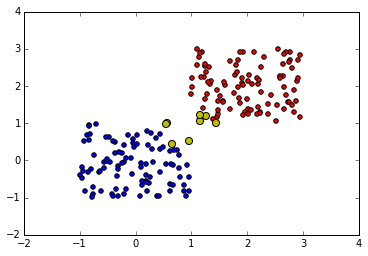

In [1045]:
'''
code snippet to plot the data points and the support vectors

'''


n=np.shape(x)[0]/2
x1= np.array(x[0:n])
x2=np.array(x[n:])
support_vec_x = np.array(support_vec_x)

plt.scatter(x1[:,0],x1[:,1],c='r')
plt.scatter(x2[:,0],x2[:,1])
plt.scatter(support_vec_x[:,0],support_vec_x[:,1],s=50,c="y")